In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import missingno as msno

# Funciones de Soporte (Helpers)

In [3]:
def map_languages(row) -> pd.Series:
    """
    En este método vamos a emular un OneHot encoding pero a mano.
    Recibe como parámetro el registro y devuelve el nuevo registro actualizado
    """
    # print(row['lenguajes_array'])
    languages = (row['lenguajes_array'])
    errors = 0
    try:
      for l in languages:
        if l != '':
          row[str.lower(l)] = 1
        else:
          errors += 1 # El lenguaje es '' string :(
    except:
      errors += 1

    # print('Count Errors:', errors)
    return row

# Trabajo Final

### Hipótesis

- Pregunta #1: Que salario o rango debería asignarle basado en mis variables?
    - Años de Experiencia / Seniority
    - Tecnologías (Lenguajes de Programación)
    - Lugar de Residencia
    - Dedicación
    - Estudios alcanzados
    - Posición
    - Tipo de Contrato
- Pregunta #2: Cuanta influencia tiene la locación del profesional? Es mas caro un DEV en Bs As que en Formosa?
- Pregunta #3: Cuanto influye la educación formal? vemos mejores salarios para los que hayan adquirido una educación Universitaria?

## Limpeza de Datos y Armado de DataSet (Data Wrangling)

In [4]:
# tomamos el DataSet y hacemos un poco de limpieza
#   -> Renombrar columnas para mejorar su legibilidad
#   -> Removemos algunas columnas que no son necesarios

df_salary = pd.read_csv('https://raw.githubusercontent.com/mauriciobergallo/coderhouse-datascience/refs/heads/main/datasets/encuesta-salarial-2024.csv', skiprows=0,
                        thousands=".",
                        decimal=",",)
df_salary.rename(columns={'Unnamed: 0': 'indice', '_sal': 'salario', \
    'lenguajes_de_programacion_o_tecnologias_que_utilices_en_tu_puesto_actual': 'lenguajes', \
    'donde_estas_trabajando': 'lugar_residencia', 'trabajo_de': 'posicion'}, inplace=True)
df_salary.drop(columns={'indice'}, inplace=True)

df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 48 columns):
 #   Column                                                                                Non-Null Count  Dtype  
---  ------                                                                                --------------  -----  
 0   lugar_residencia                                                                      5490 non-null   object 
 1   dedicacion                                                                            5490 non-null   object 
 2   tipo_de_contrato                                                                      5490 non-null   object 
 3   ultimo_salario_mensual_o_retiro_bruto_en_pesos_argentinos                             5490 non-null   int64  
 4   ultimo_salario_mensual_o_retiro_neto_en_pesos_argentinos                              5214 non-null   float64
 5   pagos_en_dolares                                                                   

In [5]:
# Removemos algunas columnas que no vamos a tener en cuenta
df_salary.drop(columns={
    'bases_de_datos',
    'ultimo_salario_mensual_o_retiro_bruto_en_pesos_argentinos',
    'ultimo_salario_mensual_o_retiro_neto_en_pesos_argentinos',
    'pagos_en_dolares',
    'si_tu_sueldo_esta_dolarizado_cual_fue_el_ultimo_valor_del_dolar_que_tomaron',
    'recibis_algun_tipo_de_bono',
    'a_que_esta_atado_el_bono',
    'tuviste_actualizaciones_de_tus_ingresos_laborales_durante_2024',
    'de_que_fue_el_ajuste_total_acumulado',
    'en_que_mes_fue_el_ultimo_ajuste',
    'como_consideras_que_estan_tus_ingresos_laborales_comparados_con_el_semestre_anterior',
    'contas_con_beneficios_adicionales',
    'que_tan_conforme_estas_con_tus_ingresos_laborales',
    'estas_buscando_trabajo',
    'antiguedad_en_la_empresa_actual',
    'cuantas_personas_tenes_a_cargo',
    'plataformas_que_utilizas_en_tu_puesto_actual',
    'frameworksherramientas_y_librerias_que_utilices_en_tu_puesto_actual',
    'qa_testing',
    'cantidad_de_personas_en_tu_organizacion',
    'modalidad_de_trabajo',
    'si_trabajas_bajo_un_esquema_hibrido_cuantos_dias_a_la_semana_vas_a_la_oficina',
    'en_los_ultimos_6_mesesse_aplico_alguna_politica_de_ajustes_salariales',
    'en_los_ultimos_6_meseshubo_reduccion_de_personal',
    'la_recomendas_como_un_buen_lugar_para_trabajar',
    'que_tanto_estas_usando_copilotchatgpt_u_otras_herramientas_de_ia_para_tu_trabajo',
    'anos_en_el_puesto_actual',
    'salir_o_seguir_contestando',
    'estado',
    'carrera',
    'institucion_educativa',
    'salir_o_seguir_contestando_sobre_las_guardias',
    'tenes_guardias',
    'cuanto_cobras_por_guardia',
    'aclara_el_numero_que_ingresaste_en_el_campo_anterior',
    'salir_o_seguir_contestando_sobre_estudios',
    'tengo_edad',
    'genero',
    'sueldo_dolarizado'
}, inplace=True)

df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   lugar_residencia          5490 non-null   object
 1   dedicacion                5490 non-null   object
 2   tipo_de_contrato          5490 non-null   object
 3   posicion                  5490 non-null   object
 4   anos_de_experiencia       5490 non-null   int64 
 5   lenguajes                 5488 non-null   object
 6   maximo_nivel_de_estudios  2567 non-null   object
 7   seniority                 5490 non-null   object
 8   salario                   5490 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 386.1+ KB


In [6]:
# Categorizar columnas
#   -> Dedicación
#   -> TipoDeContrato
#   -> MaximoNivelDeEstudio
#   -> Seniority
df_salary['dedicacion'] = df_salary['dedicacion'].astype('category')
df_salary['tipo_de_contrato'] = df_salary['tipo_de_contrato'].astype('category')
df_salary['maximo_nivel_de_estudios'] = df_salary['maximo_nivel_de_estudios'].astype('category')
df_salary['seniority'] = df_salary['seniority'].astype('category')
df_salary['lugar_residencia'] = df_salary['lugar_residencia'].astype('category')

df_salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   lugar_residencia          5490 non-null   category
 1   dedicacion                5490 non-null   category
 2   tipo_de_contrato          5490 non-null   category
 3   posicion                  5490 non-null   object  
 4   anos_de_experiencia       5490 non-null   int64   
 5   lenguajes                 5488 non-null   object  
 6   maximo_nivel_de_estudios  2567 non-null   category
 7   seniority                 5490 non-null   category
 8   salario                   5490 non-null   int64   
dtypes: category(5), int64(2), object(2)
memory usage: 200.0+ KB


In [7]:
# Verificamos la cantidad de NaN en el DataFrame 
df_salary.isna().sum()

lugar_residencia               0
dedicacion                     0
tipo_de_contrato               0
posicion                       0
anos_de_experiencia            0
lenguajes                      2
maximo_nivel_de_estudios    2923
seniority                      0
salario                        0
dtype: int64

Nota: Vemos que hay 2 NaN para 'lenguajes' y 2923 para 'maximo_nivel_de_estudio',  por lo cual usaremos dos técnicas distintas, eliminar los registros para los cuales lenguajes es NaN (sabemos que no nos sirven debido a que vamos a utilizar los lenguajes como campo para predecir), y en el caso de 'maximmo_nivel_de_estudios' tomamos la MODA de la columna. 

In [8]:
# Mostramos las filas a borrar
df_filas_a_borrar = df_salary.loc[df_salary['lenguajes'].isna()]
df_filas_a_borrar

,lugar_residencia,dedicacion,tipo_de_contrato,posicion,anos_de_experiencia,lenguajes,maximo_nivel_de_estudios,seniority,salario
2195,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Infosec,1,NaN,Universitario,Junior,1371000
4163,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Scrum Master,10,NaN,NaN,Senior,3109560


In [9]:
# Eliminamos dichas filas
df_filas_a_borrar.index
df_salary.drop(index=df_filas_a_borrar.index, inplace=True)

In [10]:
# Calculamos la moda de 'maximo_nivel_de_educacion' para reemplazar en los valores nulos 
df_salary['maximo_nivel_de_estudios'].mode()

0    Universitario
Name: maximo_nivel_de_estudios, dtype: category
Categories (8, object): ['Doctorado', 'Maestría', 'Posdoctorado', 'Posgrado/Especialización', 'Primario', 'Secundario', 'Terciario', 'Universitario']

In [11]:
# Reemplazamos los valores NaN con la MODA
df_salary.fillna(value={ 'maximo_nivel_de_estudios': 'Universitario' }, inplace=True)

In [12]:
# Volvemos a listar los NaN
df_salary.isna().sum()

lugar_residencia            0
dedicacion                  0
tipo_de_contrato            0
posicion                    0
anos_de_experiencia         0
lenguajes                   0
maximo_nivel_de_estudios    0
seniority                   0
salario                     0
dtype: int64

In [13]:
# Filtramos posiciones relacionadas a desarrollo web

profession_filter = ['Developer', 'Technical Leader', 'Data Engineer', 'Automatizador', \
    'Consultant', 'Data Scientist', 'Architect', 'Engineer', 'Machine Learning Engineer', \
        'Analista Senior en Informatica', 'AI Engineer', 'Operaciones', \
            'Hago desde el análisis y la programación. Diseño de DB, etc', 'Analista Tecnico Funcional', \
                'Ingenieria Electronica', 'Técnico en informática']

df_salary.where(df_salary['posicion'].isin(profession_filter), inplace=True)

# Reindexamos para evitar problemas de índice
df_salary = df_salary.dropna().reset_index(drop=True)
df_salary.tail()


,lugar_residencia,dedicacion,tipo_de_contrato,posicion,anos_de_experiencia,lenguajes,maximo_nivel_de_estudios,seniority,salario
2953,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Data Engineer,5.0,"Bash/Shell, Python, Scala",Universitario,Semi-Senior,2200000.0
2954,Ciudad Autónoma de Buenos Aires,Part-Time,Staff (planta permanente),Developer,4.0,"Bash/Shell, CSS, HTML, Java, Javascript, Scala...",Universitario,Semi-Senior,1700000.0
2955,Buenos Aires,Full-Time,Tercerizado (trabajo a través de consultora o ...,Developer,5.0,"CSS, HTML, Javascript, TypeScript",Terciario,Semi-Senior,2500000.0
2956,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Technical Leader,30.0,SQL,Universitario,Senior,4000000.0
2957,Buenos Aires,Full-Time,Staff (planta permanente),Developer,5.0,"HTML, Javascript, PHP, Rust, SQL",Universitario,Semi-Senior,1290000.0


In [14]:
# Actualmente los lenguajes de programación vienen en un string separados por coma y espacio (', '); por ende, vamos a separarlos en un array y 
# usarlos como columnas

# Para ello:
# Spliteamos los lenguajes de programación en un array dentro de la columna nueva lenguajes_array
df_salary['lenguajes_array'] = df_salary['lenguajes'] \
    .apply(func=(lambda x: str(x).split(', ')))

# Con este pedazo de código lo que hacemos es crear las columnas de los lenguajes de programación,
# además lo limpiamos un poco
languages_list = df_salary['lenguajes_array'].to_list()

df_languages = pd.DataFrame(languages_list)
unique_languages = pd.unique(np.char.lower(df_languages.stack().to_numpy().tolist()))

df_unique_languages = pd.DataFrame(unique_languages).replace('', np.nan).dropna()
unique_languages_list = pd.unique(np.char.lower(df_unique_languages.stack().to_numpy().tolist()))

lenguages_columns_length = unique_languages_list.shape[0]
lenguages_rows_length = df_salary.shape[0]

languages_df = pd.DataFrame(np.zeros((lenguages_rows_length, lenguages_columns_length)), columns=unique_languages_list)
final_df = pd.concat([df_salary, languages_df], axis=1)

In [15]:
# Aplicamos la función map_languages, que simula un OneHotEncoder a mano
final_df_encoded = final_df.apply(map_languages, axis=1)

# Mostramos un poco los resultados...
final_df_encoded[['lenguajes', 'html', 'javascript', 'c#', 'seniority', 'anos_de_experiencia', 'tipo_de_contrato', 'salario']].head()

# Creo un nuevo CSV con las columnas para verlas mejor y poder elegir cual eliminar y cual no
# df_columns_to_clean = final_df_encoded.columns.to_frame()
# df_columns_to_clean.to_csv('./datasets/coolumns_for_cleaning.csv')

# Elimino nuevamente algunas columnas que considero "no útiles"
final_df_encoded.drop(columns={
    'ninguno de los anteriores',
    'relacionados a salesforce: apex',
    'una poronga',
    'sap pi po is',
    'tal',
    'edi',
    'microsoft excel',
    'openedge abl',
    'soql ',
    'no trabajo con lenguajes sino que realizo diseño de arquitecturas a alto nivel',
    'no hago programacion',
    'wikimedia',
    'actualmente me encuentro entre asignaciones',
    'pero mi perfil en la empresa es de java y angularts',
    'vb .net  y vb .6',
    'lenguajes', 
    'lenguajes_array'
}, inplace=True)

# Vuelvo a Eliminar NaN en caso de que me hayan quedado
final_df_encoded = final_df_encoded.dropna().reset_index(drop=True)


## Informe sobre el DataSet ya limpio

In [16]:
# Asignación
df = final_df_encoded

In [17]:
# Forma
print(df.shape)

(2958, 125)


In [18]:
# Describimos el DataSet
df.describe().T

,count,mean,std,min,25%,50%,75%,max
anos_de_experiencia,2958.0,7.323191e+00,6.625981e+00,0.0,3.0,5.0,10.0,3.900000e+01
salario,2958.0,6.130852e+06,3.502636e+07,120000.0,1150000.0,1850000.0,3000000.0,1.105953e+09
html,2958.0,3.820149e-01,4.859623e-01,0.0,0.0,0.0,1.0,1.000000e+00
javascript,2958.0,5.463151e-01,4.979345e-01,0.0,0.0,1.0,1.0,1.000000e+00
php,2958.0,1.260987e-01,3.320167e-01,0.0,0.0,0.0,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...
sqr,2958.0,3.380663e-04,1.838658e-02,0.0,0.0,0.0,0.0,1.000000e+00
vbscript,2958.0,3.380663e-04,1.838658e-02,0.0,0.0,0.0,0.0,1.000000e+00
blue prism,2958.0,3.380663e-04,1.838658e-02,0.0,0.0,0.0,0.0,1.000000e+00
poweshell,2958.0,3.380663e-04,1.838658e-02,0.0,0.0,0.0,0.0,1.000000e+00


In [19]:
# Perimeros 10 Registros
df.head(10)

,lugar_residencia,dedicacion,tipo_de_contrato,posicion,anos_de_experiencia,maximo_nivel_de_estudios,seniority,salario,html,javascript,...,rexx,ssis,graphql,mulesoft,iron python,sqr,vbscript,blue prism,poweshell,classic asp
0,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Developer,3.0,Posgrado/Especialización,Semi-Senior,1700000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Buenos Aires,Full-Time,Staff (planta permanente),Technical Leader,3.0,Universitario,Semi-Senior,2000000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Córdoba,Full-Time,Contractor,Data Engineer,5.0,Universitario,Semi-Senior,1000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Developer,9.0,Universitario,Senior,850000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ciudad Autónoma de Buenos Aires,Full-Time,Contractor,Technical Leader,5.0,Universitario,Semi-Senior,3300000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Córdoba,Full-Time,Contractor,Automatizador,0.0,Universitario,Junior,450000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Córdoba,Full-Time,Staff (planta permanente),Technical Leader,9.0,Universitario,Senior,835469.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Buenos Aires,Full-Time,Contractor,Technical Leader,3.0,Universitario,Semi-Senior,1050000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Developer,4.0,Universitario,Semi-Senior,860000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Corrientes,Full-Time,Contractor,Developer,15.0,Posgrado/Especialización,Senior,4000000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Últimos 10 Registros
df.tail(10)

,lugar_residencia,dedicacion,tipo_de_contrato,posicion,anos_de_experiencia,maximo_nivel_de_estudios,seniority,salario,html,javascript,...,rexx,ssis,graphql,mulesoft,iron python,sqr,vbscript,blue prism,poweshell,classic asp
2948,Santa Fe,Full-Time,Staff (planta permanente),Technical Leader,4.0,Universitario,Semi-Senior,1768000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2949,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Data Engineer,3.0,Universitario,Semi-Senior,1534351.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2950,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Developer,2.0,Universitario,Junior,797000.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2951,Córdoba,Full-Time,Staff (planta permanente),Architect,3.0,Universitario,Semi-Senior,3000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2952,Mendoza,Full-Time,Staff (planta permanente),Data Engineer,0.0,Universitario,Junior,750000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2953,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Data Engineer,5.0,Universitario,Semi-Senior,2200000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2954,Ciudad Autónoma de Buenos Aires,Part-Time,Staff (planta permanente),Developer,4.0,Universitario,Semi-Senior,1700000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2955,Buenos Aires,Full-Time,Tercerizado (trabajo a través de consultora o ...,Developer,5.0,Terciario,Semi-Senior,2500000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2956,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),Technical Leader,30.0,Universitario,Senior,4000000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2957,Buenos Aires,Full-Time,Staff (planta permanente),Developer,5.0,Universitario,Semi-Senior,1290000.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Análisis de variables Categóricas

- Por cada variable categórica mostramos la cantidad de dichas ocurrencias
- Además usamos Scatterplot para mostrar la distribución de los valores por cada categoría

<Axes: >

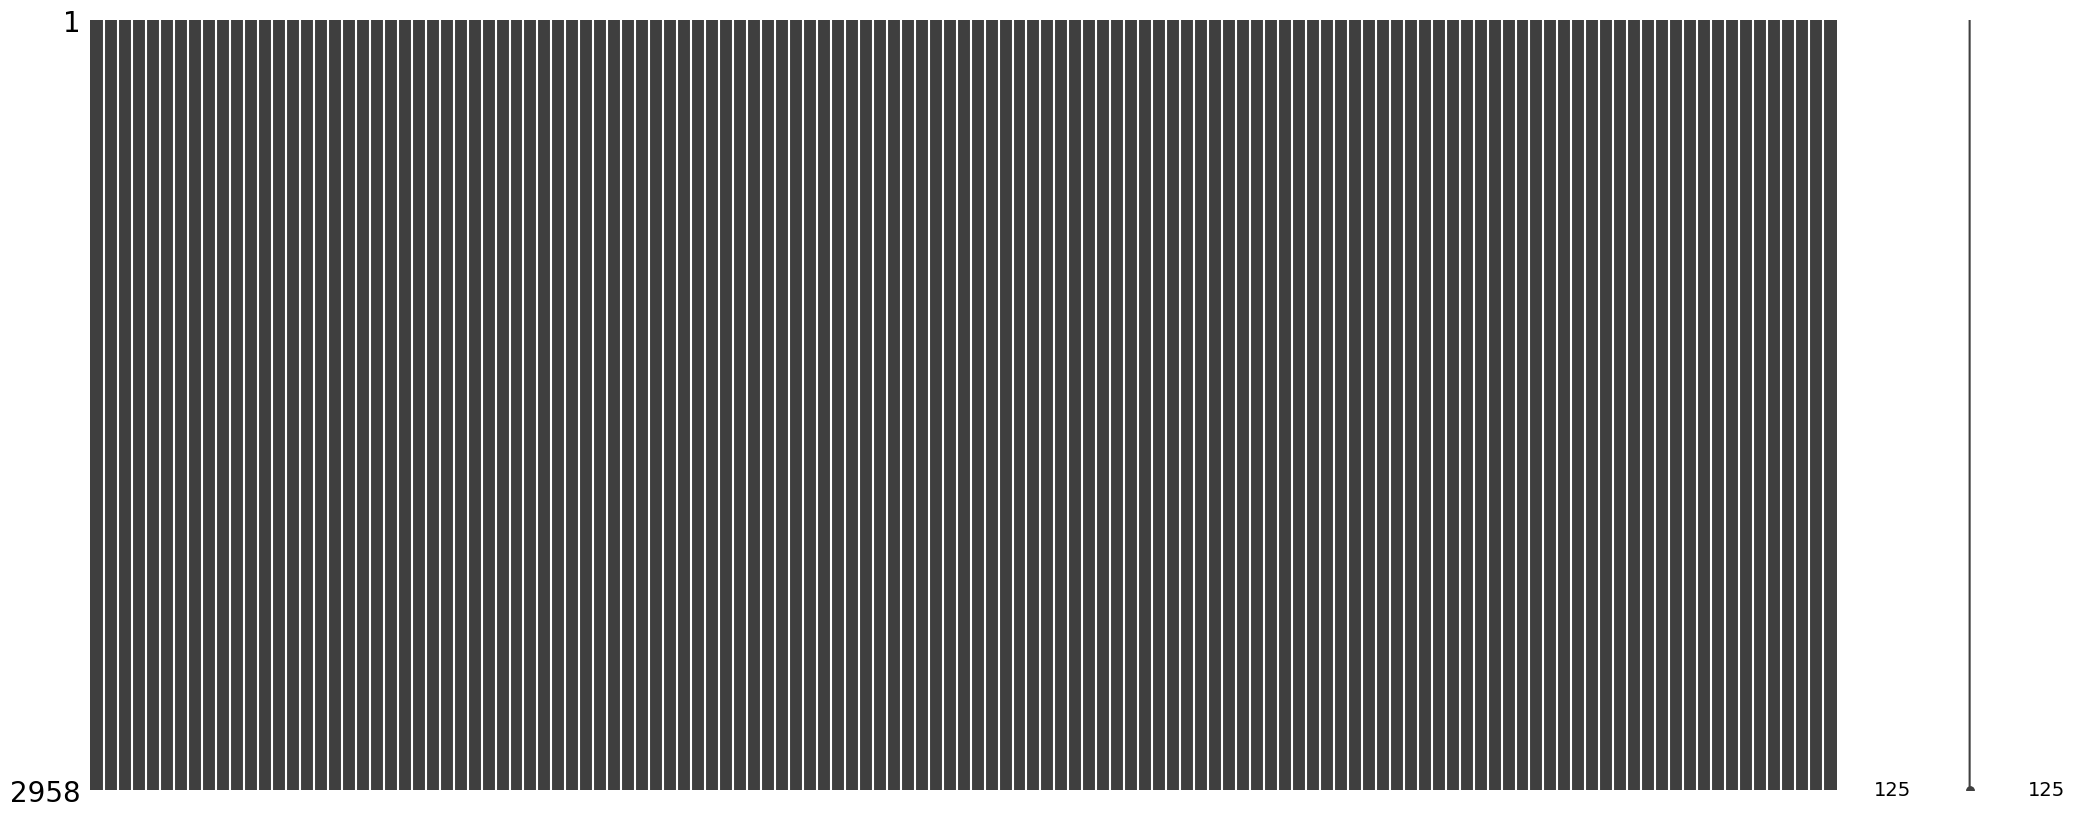

In [21]:
# Mostramos que no hay valores nulos o vacíos
msno.matrix(df)

In [22]:
# Algunas columnas
print(df.columns)

Index(['lugar_residencia', 'dedicacion', 'tipo_de_contrato', 'posicion',
       'anos_de_experiencia', 'maximo_nivel_de_estudios', 'seniority',
       'salario', 'html', 'javascript',
       ...
       'rexx', 'ssis', 'graphql', 'mulesoft ', 'iron python', 'sqr',
       'vbscript', 'blue prism', 'poweshell', 'classic asp'],
      dtype='object', length=125)


In [23]:
# Creamos un DF de soporte para poder mostrar los valores de Salario expresado en $1.000.000
# df_copy = df
# df_copy['salario_en_millones'] = df_copy['salario'] / 1000000
# df_copy[['salario', 'salario_en_millones']]
df['salario_en_millones'] = df['salario'] / 1000000
df[['salario', 'salario_en_millones']]

,salario,salario_en_millones
0,1700000.0,1.70
1,2000000.0,2.00
2,1000000.0,1.00
3,850000.0,0.85
4,3300000.0,3.30
...,...,...
2953,2200000.0,2.20
2954,1700000.0,1.70
2955,2500000.0,2.50
2956,4000000.0,4.00


### Codificación de variables categóricas

Para un mejor análisis posterior (los algoritmos deben trabajar con valores numéricos), debemos codificar (encoding) de las variables categóricas. Utilizaremos el LabelEncoder debido a que no es la idea agregar mas columnas al DataSet.

In [24]:
# Ya que son Strings (cadenas de caracteres), utilizamos LabelEncoder
encoder = LabelEncoder()
df['seniority_encoded'] = encoder.fit_transform(df['seniority'])
df['lugar_residencia_encoded'] = encoder.fit_transform(df['lugar_residencia'])
df['dedicacion_encoded'] = encoder.fit_transform(df['dedicacion'])
df['tipo_de_contrato_encoded'] = encoder.fit_transform(df['tipo_de_contrato'])
df['maximo_nivel_de_estudios_encoded'] = encoder.fit_transform(df['maximo_nivel_de_estudios'])
df[['seniority', 'seniority_encoded', \
    'lugar_residencia', 'lugar_residencia_encoded', \
    'dedicacion', 'dedicacion_encoded', \
    'tipo_de_contrato', 'tipo_de_contrato_encoded', \
    'maximo_nivel_de_estudios', 'maximo_nivel_de_estudios_encoded']]

,seniority,seniority_encoded,lugar_residencia,lugar_residencia_encoded,dedicacion,dedicacion_encoded,tipo_de_contrato,tipo_de_contrato_encoded,maximo_nivel_de_estudios,maximo_nivel_de_estudios_encoded
0,Semi-Senior,1,Ciudad Autónoma de Buenos Aires,4,Full-Time,0,Staff (planta permanente),3,Posgrado/Especialización,3
1,Semi-Senior,1,Buenos Aires,0,Full-Time,0,Staff (planta permanente),3,Universitario,7
2,Semi-Senior,1,Córdoba,6,Full-Time,0,Contractor,0,Universitario,7
3,Senior,2,Ciudad Autónoma de Buenos Aires,4,Full-Time,0,Staff (planta permanente),3,Universitario,7
4,Semi-Senior,1,Ciudad Autónoma de Buenos Aires,4,Full-Time,0,Contractor,0,Universitario,7
...,...,...,...,...,...,...,...,...,...,...
2953,Semi-Senior,1,Ciudad Autónoma de Buenos Aires,4,Full-Time,0,Staff (planta permanente),3,Universitario,7
2954,Semi-Senior,1,Ciudad Autónoma de Buenos Aires,4,Part-Time,1,Staff (planta permanente),3,Universitario,7
2955,Semi-Senior,1,Buenos Aires,0,Full-Time,0,Tercerizado (trabajo a través de consultora o ...,4,Terciario,6
2956,Senior,2,Ciudad Autónoma de Buenos Aires,4,Full-Time,0,Staff (planta permanente),3,Universitario,7


### Variable: Lugar de Residencia

In [25]:
df[['lugar_residencia', 'lugar_residencia_encoded']].value_counts()

lugar_residencia                 lugar_residencia_encoded
Ciudad Autónoma de Buenos Aires  4                           1354
Buenos Aires                     0                            702
Córdoba                          6                            270
Santa Fe                         20                           199
Mendoza                          12                           112
Entre Ríos                       7                             51
Tucumán                          23                            33
Misiones                         13                            28
Chaco                            2                             26
Neuquén                          14                            22
Corrientes                       5                             20
Salta                            16                            20
San Juan                         17                            20
Río Negro                        15                            18
San Luis          

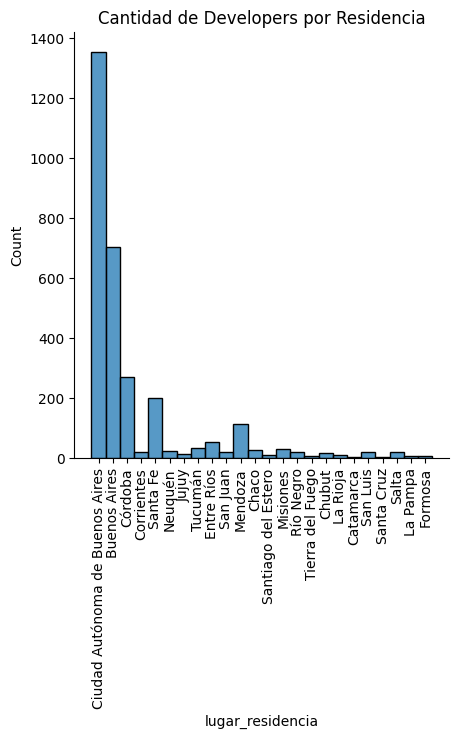

In [26]:
ax = sns.displot(data=df['lugar_residencia'])
ax.tick_params(axis='x', rotation=90)
plt.title('Cantidad de Developers por Residencia')
plt.show()

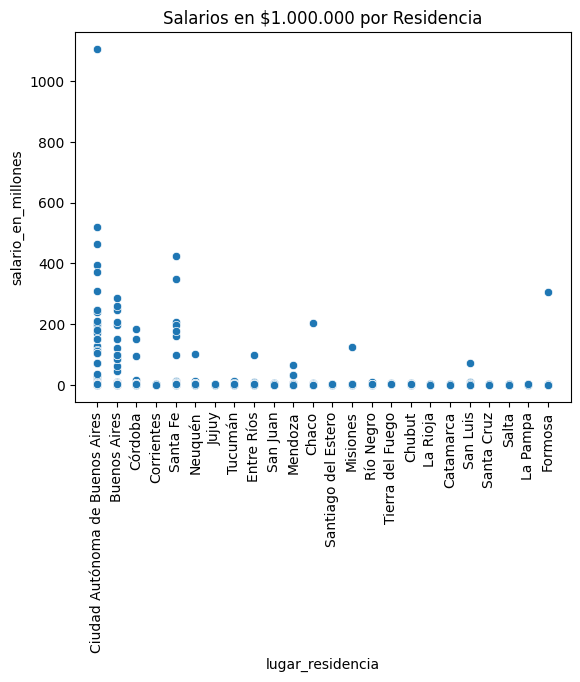

In [27]:
#Scatterplot
ax = sns.scatterplot(df, x='lugar_residencia', y='salario_en_millones')
ax.tick_params(axis='x', rotation=90)
plt.title('Salarios en $1.000.000 por Residencia')
plt.show()

### Variable:Seniority

In [28]:
print(df[['seniority', 'seniority_encoded']].value_counts())

seniority    seniority_encoded
Senior       2                    1295
Semi-Senior  1                    1004
Junior       0                     659
Name: count, dtype: int64


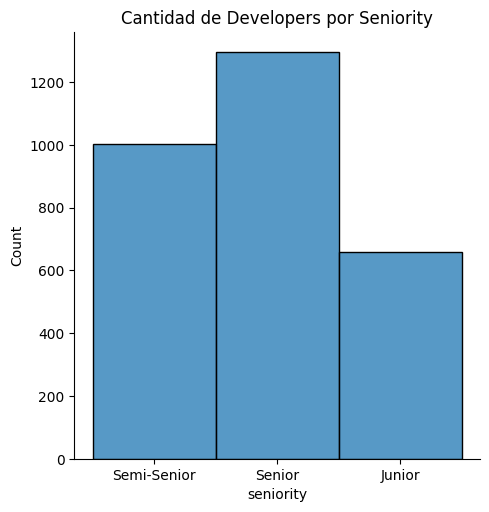

In [29]:
ax = sns.displot(data=df['seniority'])
plt.title('Cantidad de Developers por Seniority')
plt.show()

### Variable: Dedicación

In [30]:
print(df[['dedicacion', 'dedicacion_encoded']].value_counts())

dedicacion  dedicacion_encoded
Full-Time   0                     2804
Part-Time   1                      154
Name: count, dtype: int64


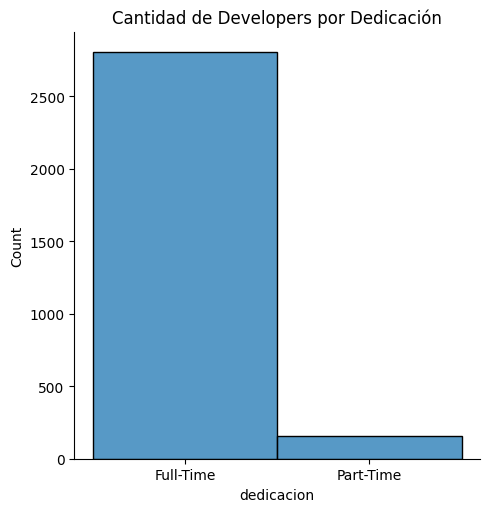

In [31]:
ax = sns.displot(data=df['dedicacion'])
plt.title('Cantidad de Developers por Dedicación')
plt.show()

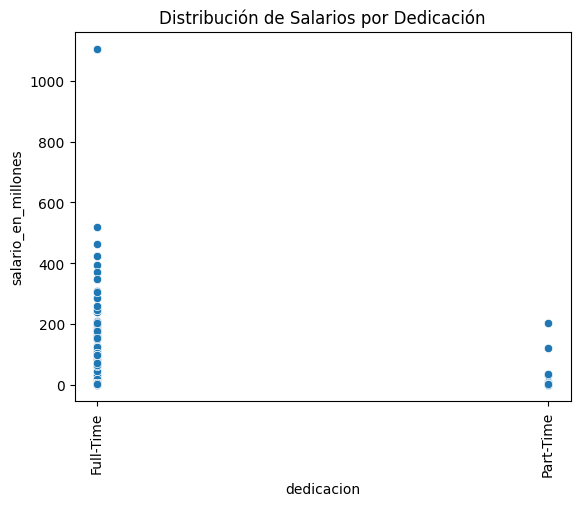

In [32]:
ax = sns.scatterplot(df, x='dedicacion', y='salario_en_millones')
ax.tick_params(axis='x', rotation=90)
plt.title('Distribución de Salarios por Dedicación')
plt.show()

### Variable: Tipo de Contrato

In [33]:
print(df[['tipo_de_contrato', 'tipo_de_contrato_encoded']].value_counts())

tipo_de_contrato                                        tipo_de_contrato_encoded
Staff (planta permanente)                               3                           2045
Contractor                                              0                            573
Tercerizado (trabajo a través de consultora o agencia)  4                            241
Freelance                                               1                             77
Participación societaria en una cooperativa             2                             22
Name: count, dtype: int64


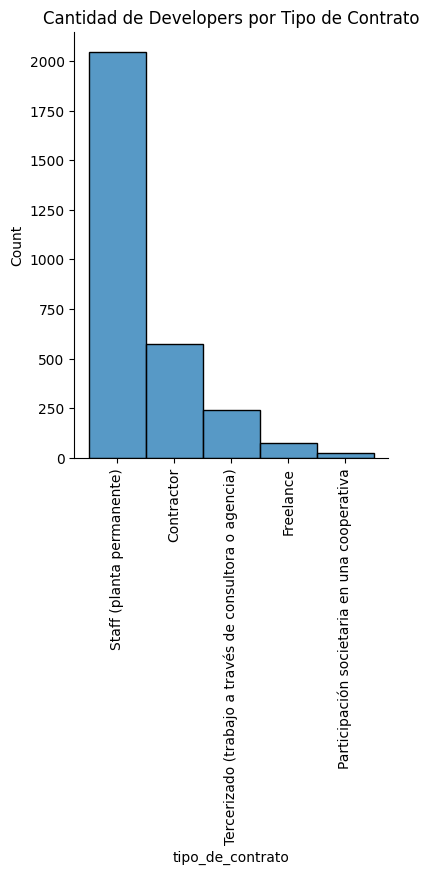

In [34]:
ax = sns.displot(data=df['tipo_de_contrato'])
ax.tick_params(axis='x', rotation=90)
plt.title('Cantidad de Developers por Tipo de Contrato')
plt.show()

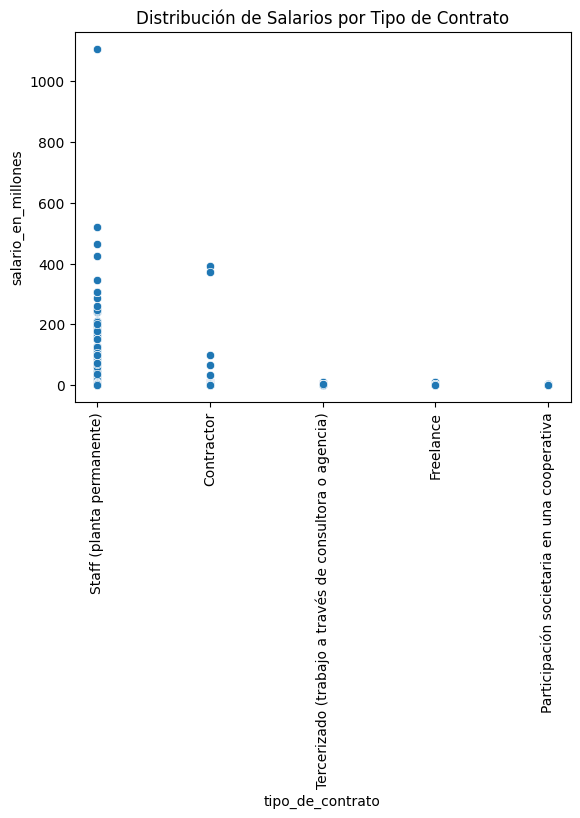

In [35]:
ax = sns.scatterplot(df, x='tipo_de_contrato', y='salario_en_millones')
ax.tick_params(axis='x', rotation=90)
plt.title('Distribución de Salarios por Tipo de Contrato')
plt.show()

### Variable: Máximo nivel de Estudio alcanzado

In [36]:
print(df[['maximo_nivel_de_estudios', 'maximo_nivel_de_estudios_encoded']].value_counts())

maximo_nivel_de_estudios  maximo_nivel_de_estudios_encoded
Universitario             7                                   2567
Terciario                 6                                    223
Secundario                5                                     56
Maestría                  1                                     47
Posgrado/Especialización  3                                     44
Doctorado                 0                                     15
Posdoctorado              2                                      5
Primario                  4                                      1
Name: count, dtype: int64


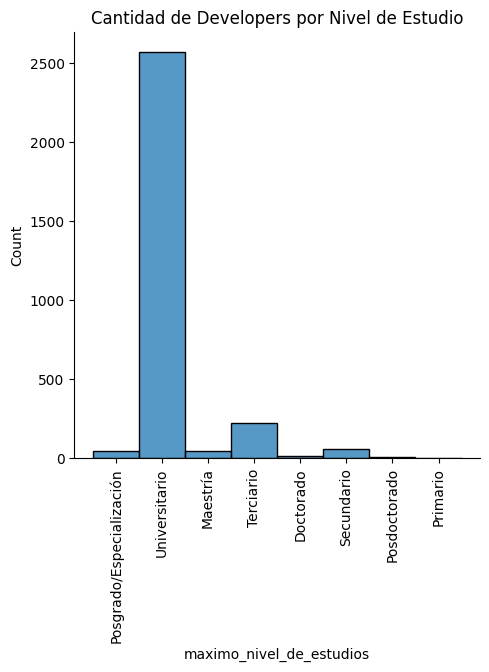

In [37]:
ax = sns.displot(data=df['maximo_nivel_de_estudios'])
ax.tick_params(axis='x', rotation=90)
plt.title('Cantidad de Developers por Nivel de Estudio')
plt.show()

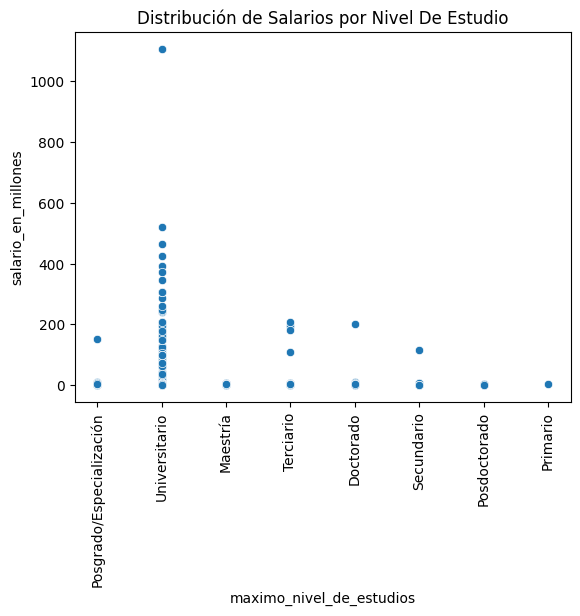

In [38]:
ax = sns.scatterplot(df, x='maximo_nivel_de_estudios', y='salario_en_millones')
ax.tick_params(axis='x', rotation=90)
plt.title('Distribución de Salarios por Nivel De Estudio')
plt.show()

### Variable: Años de Experiencia

In [39]:
print(df['anos_de_experiencia'].value_counts())

anos_de_experiencia
3.0     460
2.0     402
5.0     275
4.0     269
6.0     169
1.0     157
10.0    144
15.0    138
7.0     129
20.0    111
8.0     106
0.0     100
9.0      69
12.0     68
16.0     48
14.0     46
18.0     42
13.0     34
25.0     34
17.0     33
30.0     21
11.0     21
19.0     17
22.0     10
24.0      9
26.0      8
21.0      8
35.0      6
28.0      5
27.0      5
23.0      4
32.0      3
39.0      2
34.0      1
36.0      1
33.0      1
38.0      1
29.0      1
Name: count, dtype: int64


<Figure size 1200x2400 with 0 Axes>

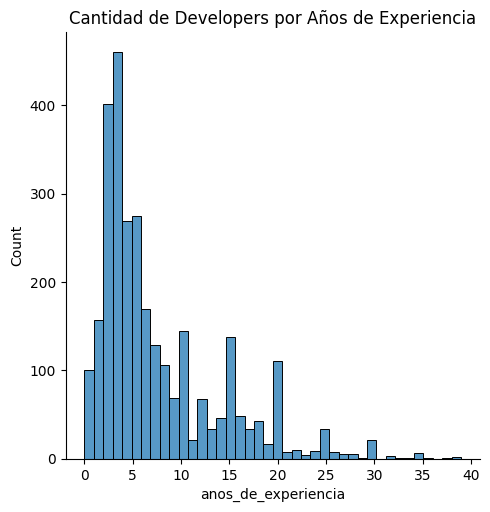

In [40]:
plt.figure(dpi = 120, figsize= (10,20))
sns.displot(data=df['anos_de_experiencia'])
plt.title('Cantidad de Developers por Años de Experiencia')
plt.show()

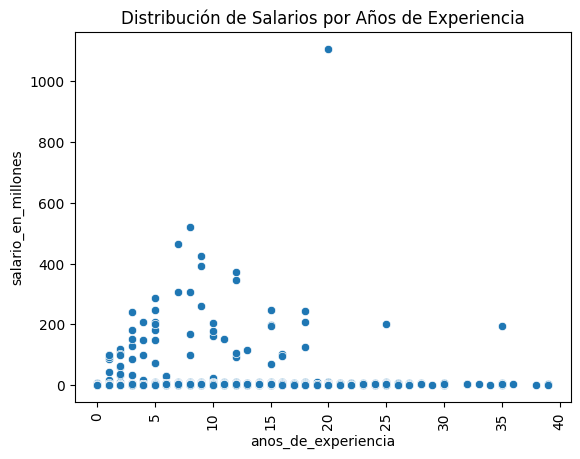

In [41]:
ax = sns.scatterplot(df, x='anos_de_experiencia', y='salario_en_millones')
ax.tick_params(axis='x', rotation=90)
plt.title('Distribución de Salarios por Años de Experiencia')
plt.show()

## Manejo de Outliers

Se identifican los outliers en el DataFrame, se procede a eliminarlos debido a que son considerados "Bad Data"

In [42]:
# Outliers

Q1 = df['salario_en_millones'].quantile(0.25)
Q3 = df['salario_en_millones'].quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
outliers = df[(df['salario_en_millones'] < Q1 - threshold * IQR) | (df['salario_en_millones'] > Q3 + threshold * IQR)]

df = df.drop(outliers.index)

## Mostramos nuevamente los gráficos por categoría

### Variable Lugar de Residencia

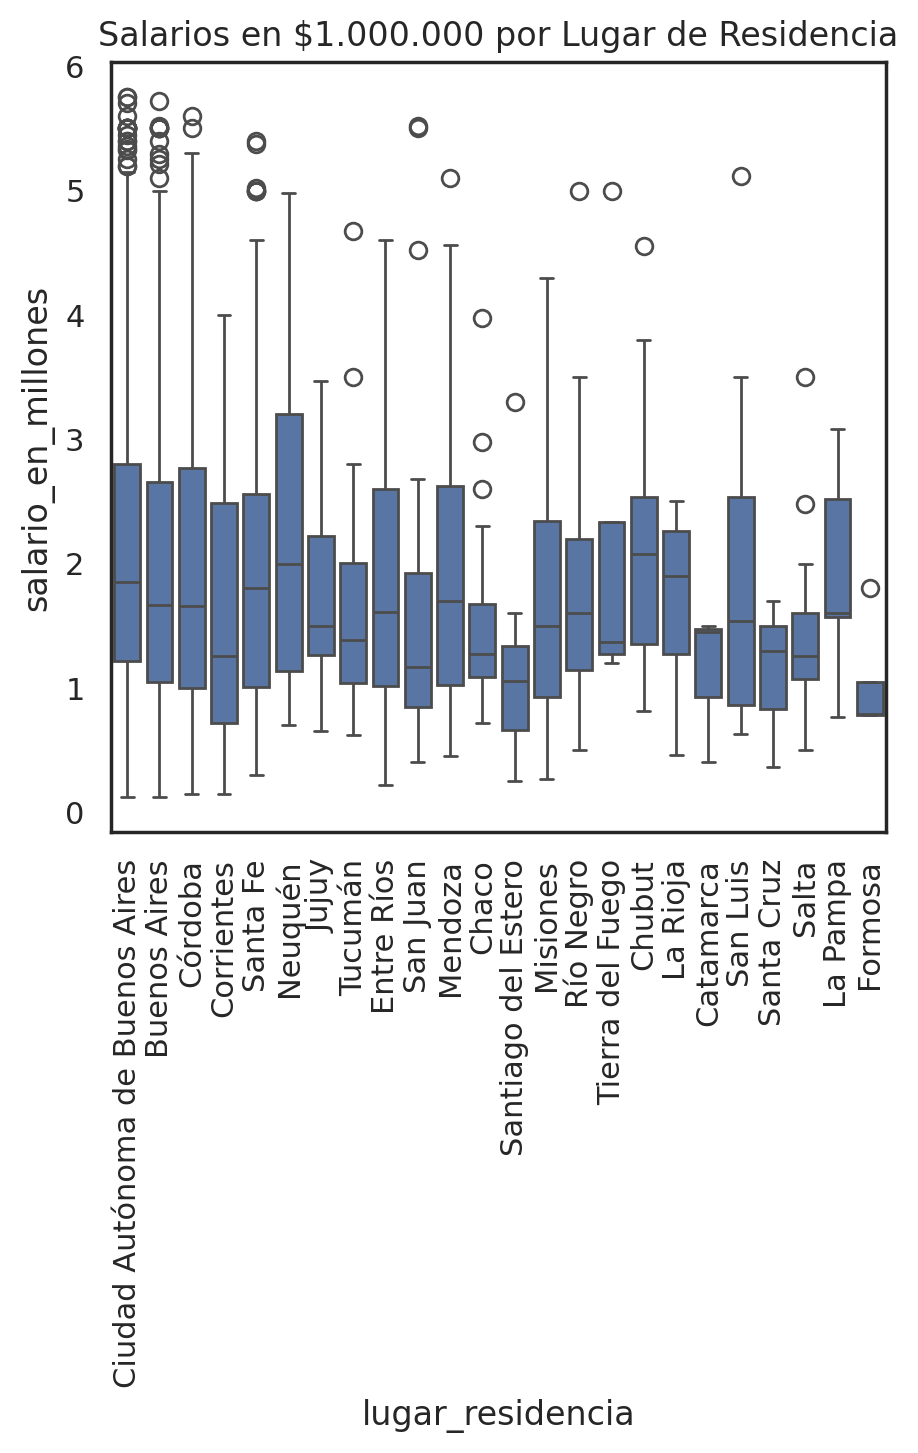

In [45]:
plt.subplots(figsize=(5, 5), dpi =200)
sns.set(style = "white")
ax = sns.boxplot(data=df, x=df['lugar_residencia'], y=df["salario_en_millones"])
plt.title('Salarios en $1.000.000 por Lugar de Residencia')
ax.tick_params(axis='x', rotation=90)
plt.show()

### Variable Seniority

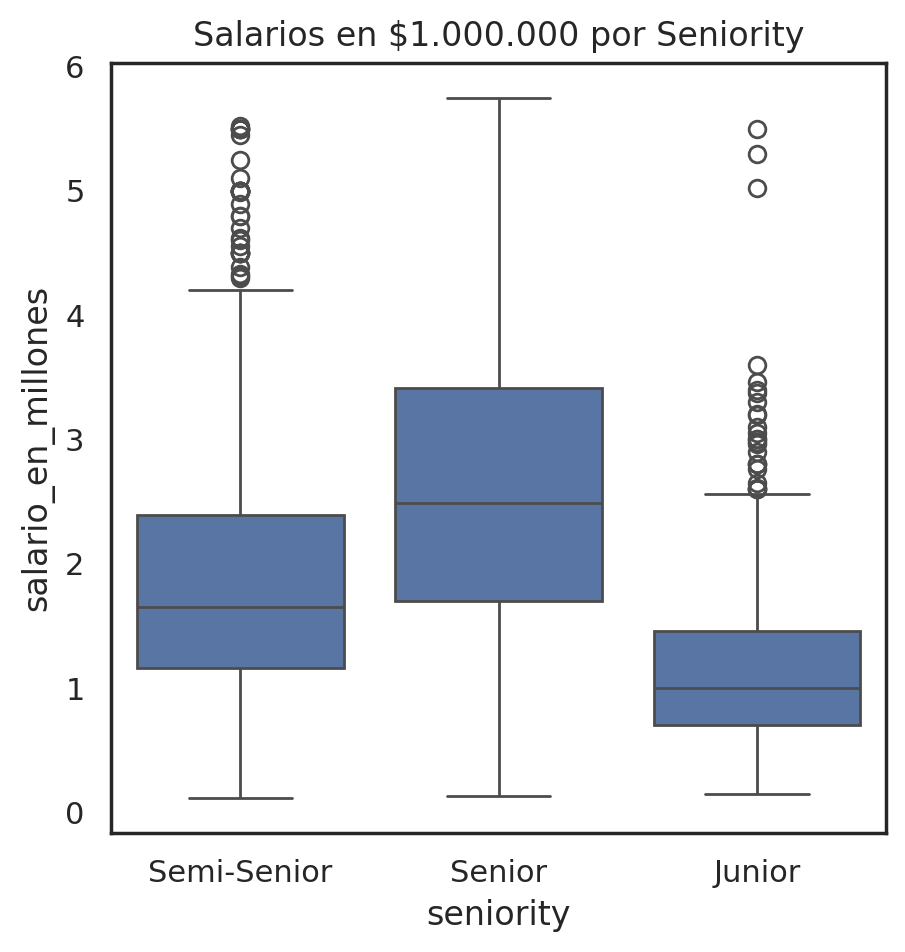

In [46]:
plt.subplots(figsize=(5, 5), dpi =200)
sns.set(style = "white")
ax = sns.boxplot(data=df, x=df['seniority'], y=df["salario_en_millones"])
plt.title('Salarios en $1.000.000 por Seniority')
plt.show()

### Variable Dedicación

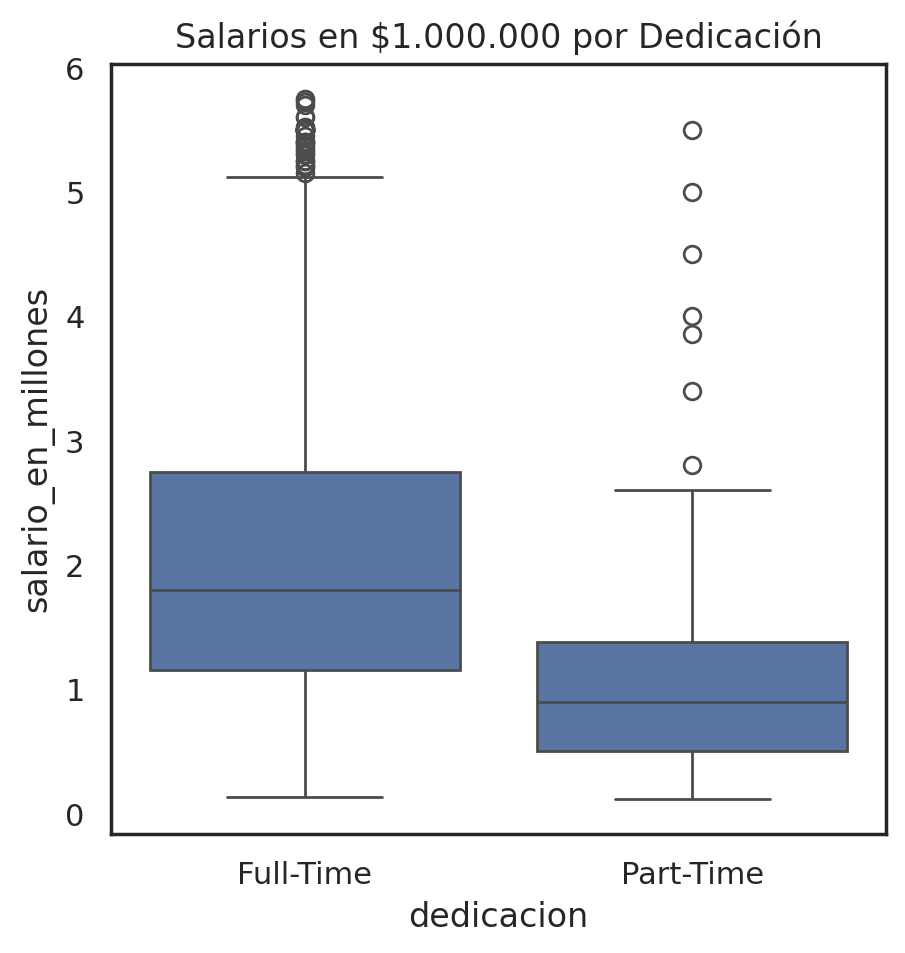

In [47]:
plt.subplots(figsize=(5, 5), dpi =200)
sns.set(style = "white")
ax = sns.boxplot(data=df, x=df['dedicacion'], y=df["salario_en_millones"])
plt.title('Salarios en $1.000.000 por Dedicación')
plt.show()

### Variable Tipo de Contrato

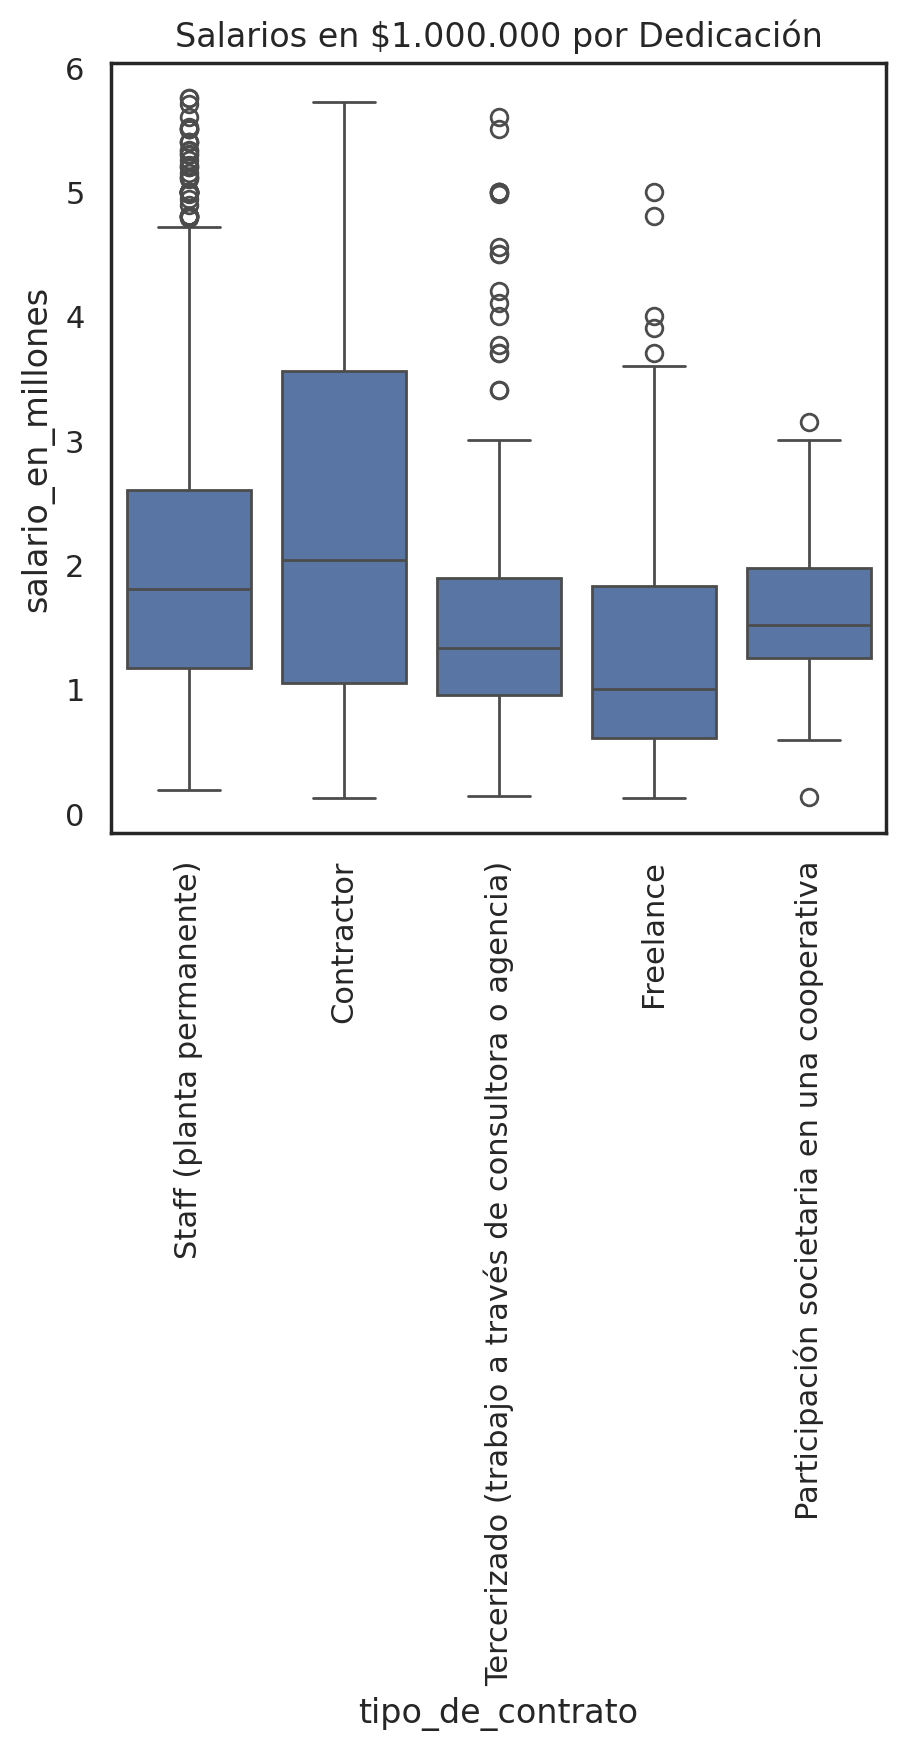

In [48]:
plt.subplots(figsize=(5, 5), dpi =200)
sns.set(style = "white")
ax = sns.boxplot(data=df, x=df['tipo_de_contrato'], y=df["salario_en_millones"])
ax.tick_params(axis='x', rotation=90)
plt.title('Salarios en $1.000.000 por Dedicación')
plt.show()

### Variable Máximo nivel de estudio alcanzado

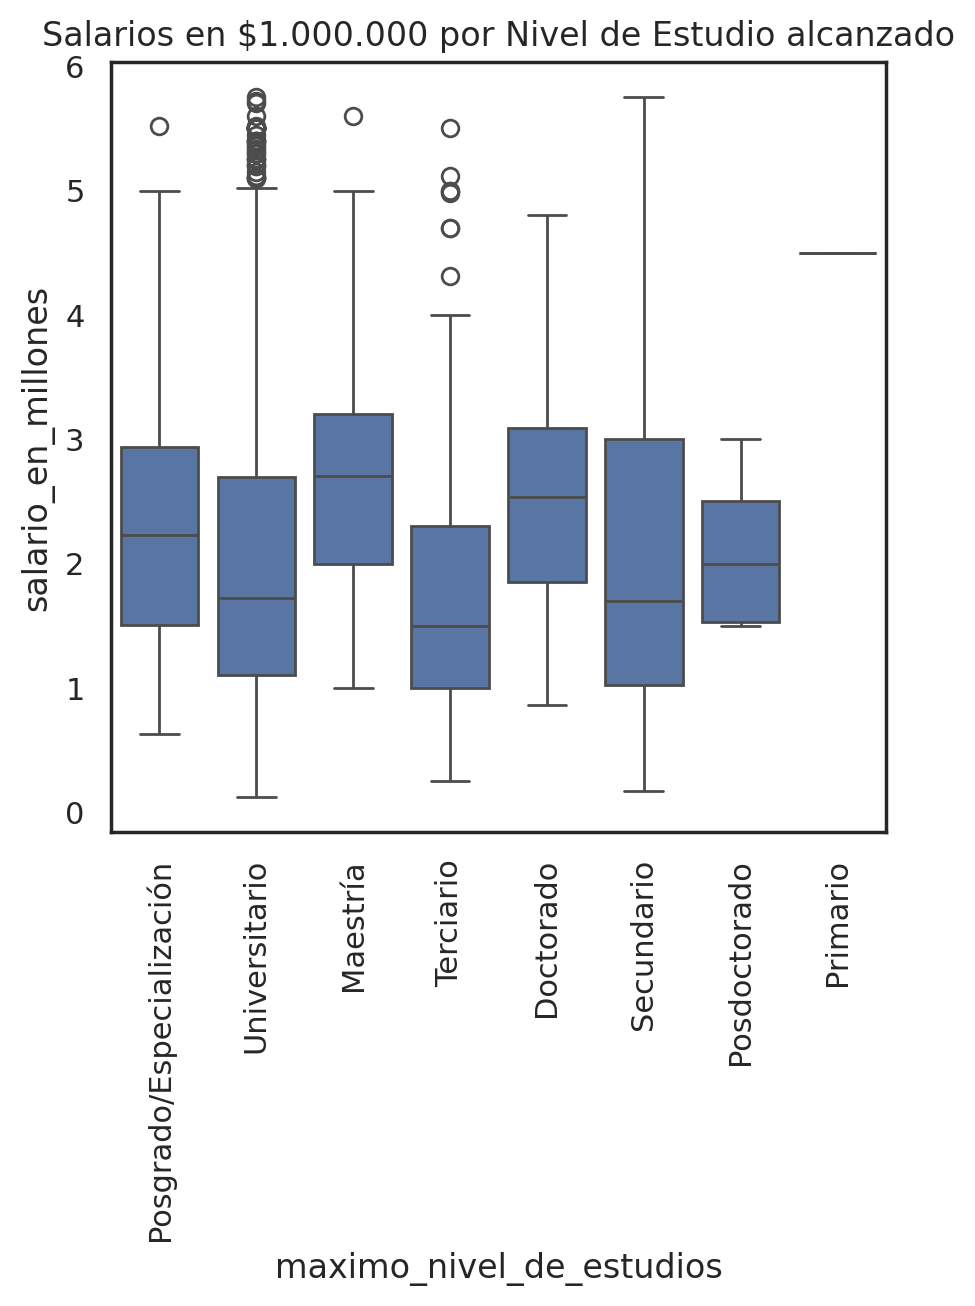

In [49]:
plt.subplots(figsize=(5, 5), dpi =200)
sns.set(style = "white")
ax = sns.boxplot(data=df, x=df['maximo_nivel_de_estudios'], y=df["salario_en_millones"])
ax.tick_params(axis='x', rotation=90)
plt.title('Salarios en $1.000.000 por Nivel de Estudio alcanzado')
plt.show()

## Conclusión del EDA



Luego del análisis EDA podemos responder dos de nuestras primeras preguntas inciales:

- Pregunta #2: Cuanta influencia tiene la locación del profesional? Es mas caro un DEV en Bs As que en Formosa?
    - La realidad es que no tanto, lo que si vemos es la cantidad de profesionales que existen en las locaciones mas pobladas como Buenos Aires - CABA, Córdoba, Rosario, etc. pero realmente no se ve una diferencia grande entre los salarios por locación.

- Pregunta #3: Cuanto influye la educación formal? vemos mejores salarios para los que hayan adquirido una educación Universitaria?
    - Lo mismo que la pregunta anterior, si bien vemos que existe una mayor cantidad de personas con estudios universitarios en los datos, no se puede apreciar una diferencia grande entre los salarios de dichas personas con respecto a los que no han alcanzado estos niveles educativos.

### Mapa de Calor para ver la relación entre dichas variables

Utilizamos un mapa de calor para intentar averiguar si hay alguna correlación entre las variables codificadas y nuestra variable target (Salario)


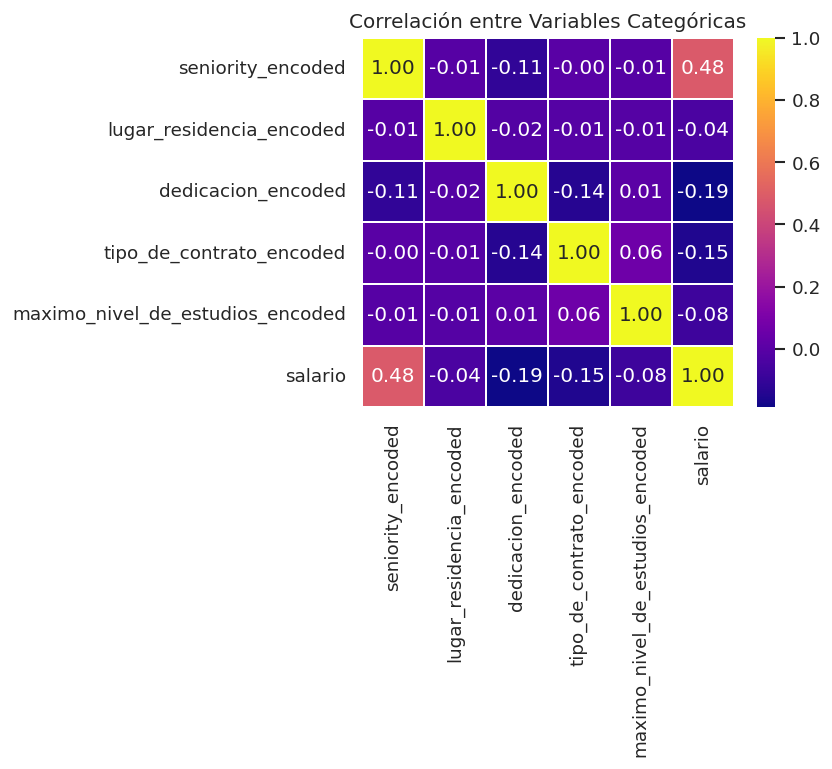

In [50]:
#Correlaciones
plt.figure(dpi = 120,figsize= (5,4))
sns.heatmap(df[['seniority_encoded', 'lugar_residencia_encoded', 'dedicacion_encoded', \
    'tipo_de_contrato_encoded', 'maximo_nivel_de_estudios_encoded', 'salario']].corr(), fmt = ".2f", annot=True, lw=1, cmap = 'plasma')
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.title('Correlación entre Variables Categóricas')
plt.show()

Conclusión: como se puede apreciar en el gráfico vemos que la feature SENIORITY es la que mas influye sobre el Salario, cosa que tiene sentido porque los salarios cambian mucho cuando un Developer es Senior / SemiSenior / Junior

## Análisis Predictivo

### Segunda Limpieza del DataSet

Para hacer un correcto análisis predictivo debemos tener el DataSet preparado para dichas operaciones, vamos a primero remover todas las columnas que no sean necesarias (las categóricas que contienen texto por ejemplo),

In [51]:
df.columns

Index(['lugar_residencia', 'dedicacion', 'tipo_de_contrato', 'posicion',
       'anos_de_experiencia', 'maximo_nivel_de_estudios', 'seniority',
       'salario', 'html', 'javascript',
       ...
       'vbscript', 'blue prism', 'poweshell', 'classic asp',
       'salario_en_millones', 'seniority_encoded', 'lugar_residencia_encoded',
       'dedicacion_encoded', 'tipo_de_contrato_encoded',
       'maximo_nivel_de_estudios_encoded'],
      dtype='object', length=131)

In [52]:
# Al ser 131 columnas no se muestra correctamente
# Creo un nuevo CSV con las columnas para verlas mejor y poder elegir cual eliminar y cual no
df_columns_to_clean = df.columns.to_frame()
df_columns_to_clean.to_csv('./datasets/coolumns_for_cleaning_1.csv')

# Ahora proceso a eliminar las que no me interesan (las variables categoricas con el texto y el salario, 
# ya que voy a usar Salario en Millones)

df.drop(columns={'lugar_residencia', 'dedicacion', 'tipo_de_contrato', 'posicion', \
    'maximo_nivel_de_estudios', 'seniority', 'salario'}, inplace=True)


df.info()
# Vemos que 131 - 7 columnas eliminadas son 124

<class 'pandas.core.frame.DataFrame'>
Index: 2744 entries, 0 to 2957
Columns: 124 entries, anos_de_experiencia to maximo_nivel_de_estudios_encoded
dtypes: float64(119), int64(5)
memory usage: 2.6 MB


## Implementación de modelos

Vamos a utilizar 3 algoritmos de regresión ya que la variable a predecir es una variable continua:
- Regresión Lineal
- Árbol de Decisión
- Random Forest

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error, \
    mean_absolute_percentage_error, mean_squared_log_error, accuracy_score

### Regresión Lineal

In [57]:
# train_set => DataSet de Entrenamiento (60%)
# val_set => DataSet de Validación (40%)
train_set, test_set = train_test_split(df, test_size=0.4, random_state=42, shuffle=True, stratify=None)

In [58]:
# Vemos como el DataSet de entrenamiento tiene el 60% de los registros
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, 2581 to 971
Columns: 124 entries, anos_de_experiencia to maximo_nivel_de_estudios_encoded
dtypes: float64(119), int64(5)
memory usage: 1.6 MB


In [59]:
# Vemos como el DataSet de test tiene el 40% de los registros
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 969 to 593
Columns: 124 entries, anos_de_experiencia to maximo_nivel_de_estudios_encoded
dtypes: float64(119), int64(5)
memory usage: 1.0 MB


In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [61]:
# Predecimos en base a los datos de test (40%)
y_test_pred = model.predict(X_test)

In [62]:
X_train = train_set.drop('salario_en_millones', axis=1)
y_train = train_set['salario_en_millones'].copy()

X_test = test_set.drop('salario_en_millones', axis=1)
y_test = test_set['salario_en_millones'].copy()

Error cuadrático medio (MSE): 0.9431966807351037
Coeficiente de determinación (R²): 0.35488411144612286
Error absoluto medio (MAE): 0.7328987934632248
Error porcentual absoluto medio (MAPE): 0.5212512267662872
Score del Modelo: 0.35488411144612286
El RMSE es: 0.9711831344988975


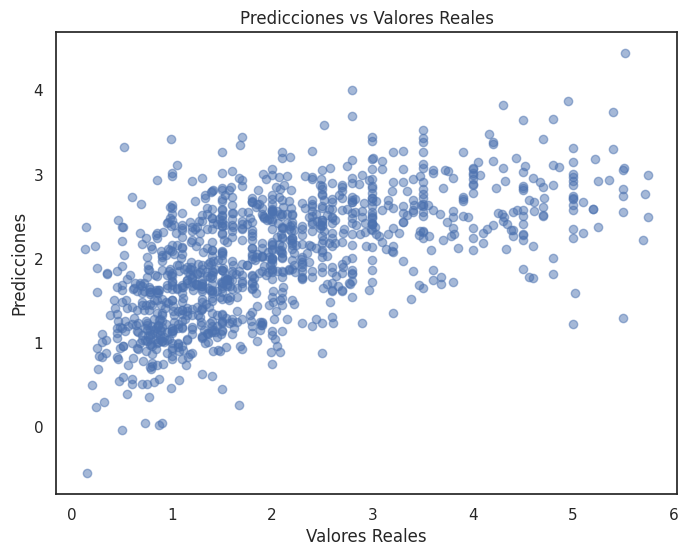

In [64]:
# Gráfico de dispersión entre predicciones y valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()

In [65]:
# Dataframe con los valores reales y predichos

df_real_pred = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred
})

df_real_pred

,Actual,Predicted
969,3.000000,2.725055
1695,1.600000,1.750004
1490,2.173000,2.223042
1522,1.300000,1.925189
2222,0.750000,1.205974
...,...,...
1770,0.969314,1.856122
2318,1.470000,2.475031
228,2.640000,1.796031
832,0.990000,1.804178


In [66]:
# Evaluación del modelo
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
mape = mean_absolute_percentage_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
score = model.score(X_test, y_test)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R²): {r2}')
print(f'Error absoluto medio (MAE): {mae}')
print(f'Error porcentual absoluto medio (MAPE): {mape}')
print(f'Score del Modelo: {score}')
# Raiz de Error Cuadratico medio (Raiz cuadrada de la distancia cuadratica promedio entre los valores reales y predichos)
print(f'El RMSE es: {rmse}')

Error cuadrático medio (MSE): 0.9431966807351037
Coeficiente de determinación (R²): 0.35488411144612286
Error absoluto medio (MAE): 0.7328987934632248
Error porcentual absoluto medio (MAPE): 0.5212512267662872
Score del Modelo: 0.35488411144612286
El RMSE es: 0.9711831344988975


Nota: Para este primer módelo de "Regresión Logistica" podemos sacar las siguientes conclusiones respecto a las métricas obtenidas:

- Error cuadrático medio (MSE): 0.9431966807351037
- Coeficiente de determinación (R²): 0.35488411144612286
- Error absoluto medio (MAE): 0.7328987934632248
- Error porcentual absoluto medio (MAPE): 0.5212512267662872
- Score del Modelo: 0.35488411144612286
- El RMSE es: 0.9711831344988975

### Árbol de Decisión

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [68]:
# train_set => DataSet de Entrenamiento (60%)
# val_set => DataSet de Validación (40%)
train_set_dt, test_set_dt = train_test_split(df, test_size=0.4, random_state=42, shuffle=True, stratify=None)

In [69]:
X_train_dt = train_set_dt.drop('salario_en_millones', axis=1)
y_train_dt = train_set_dt['salario_en_millones'].copy()

X_test_dt = test_set_dt.drop('salario_en_millones', axis=1)
y_test_dt = test_set_dt['salario_en_millones'].copy()

In [70]:
model_dt = DecisionTreeRegressor(max_depth=2, random_state=42)
model_dt.fit(X_train_dt, y_train_dt)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [71]:
# Predecimos en base a los datos de test (40%)
y_test_pred_dt = model_dt.predict(X_test_dt)

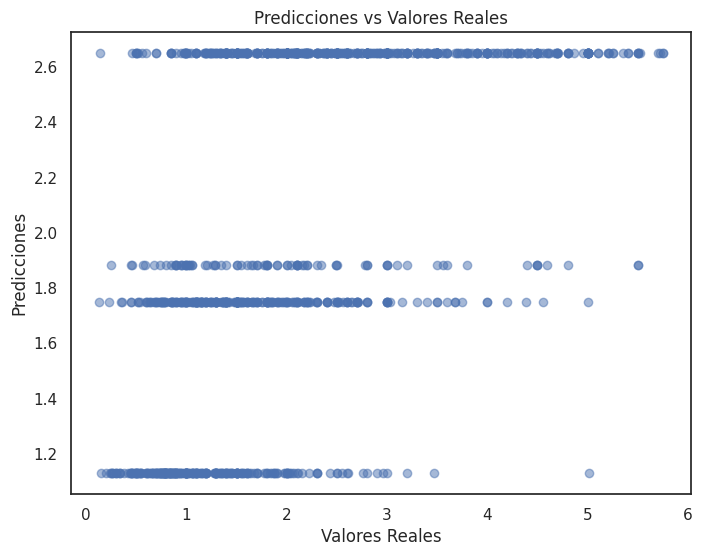

In [72]:
# Gráfico de dispersión entre predicciones y valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test_dt, y_test_pred_dt, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()

In [73]:
# Dataframe con los valores reales y predichos

df_real_pred = pd.DataFrame({
    'Actual': y_test_dt,
    'Predicted': y_test_pred_dt
})

df_real_pred

,Actual,Predicted
969,3.000000,1.881884
1695,1.600000,2.649397
1490,2.173000,1.881884
1522,1.300000,1.747607
2222,0.750000,1.129401
...,...,...
1770,0.969314,1.747607
2318,1.470000,2.649397
228,2.640000,1.747607
832,0.990000,1.747607


In [74]:
# Evaluación del modelo
mse = mean_squared_error(y_test_dt, y_test_pred_dt)
r2 = r2_score(y_test_dt, y_test_pred_dt)
mae = mean_absolute_error(y_test_dt, y_test_pred_dt)
mape = mean_absolute_percentage_error(y_test_dt, y_test_pred_dt)
rmse = np.sqrt(mse)
score = model_dt.score(X_test_dt, y_test_dt)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R²): {r2}')
print(f'Error absoluto medio (MAE): {mae}')
print(f'Error porcentual absoluto medio (MAPE): {mape}')
print(f'Score del Modelo: {score}')
print(f'El RMSE es: {rmse}')

Error cuadrático medio (MSE): 1.0498136044678448
Coeficiente de determinación (R²): 0.28196159921344344
Error absoluto medio (MAE): 0.7876255295073459
Error porcentual absoluto medio (MAPE): 0.5620726699971135
Score del Modelo: 0.28196159921344344
El RMSE es: 1.0246041208524612


Nota: Para este módelo de "Árbol de Decisión" podemos sacar las siguientes conclusiones respecto a las métricas obtenidas:

- Error cuadrático medio (MSE): 1.0498136044678448
- Coeficiente de determinación (R²): 0.28196159921344344
- Error absoluto medio (MAE): 0.7876255295073459
- Error porcentual absoluto medio (MAPE): 0.5620726699971135
- Score del Modelo: 0.28196159921344344
- El RMSE es: 1.0246041208524612

### Random Forest - Regresion Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

In [76]:
# train_set => DataSet de Entrenamiento (75%)
# val_set => DataSet de Validación (25%)
rf_train_set, rf_test_set = train_test_split(df, test_size=0.25, random_state=42, shuffle=True, stratify=None)

In [77]:
# Vemos como el DataSet de entrenamiento tiene el 75% de los registros
rf_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2058 entries, 1267 to 971
Columns: 124 entries, anos_de_experiencia to maximo_nivel_de_estudios_encoded
dtypes: float64(119), int64(5)
memory usage: 2.0 MB


In [78]:
# Vemos como el DataSet de test tiene el 40% de los registros
rf_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 686 entries, 969 to 1548
Columns: 124 entries, anos_de_experiencia to maximo_nivel_de_estudios_encoded
dtypes: float64(119), int64(5)
memory usage: 669.9 KB


In [83]:
X_train_rf = rf_train_set.drop('salario_en_millones', axis=1)
y_train_rf = rf_train_set['salario_en_millones'].copy()

X_test_rf = rf_test_set.drop('salario_en_millones', axis=1)
y_test_rf = rf_test_set['salario_en_millones'].copy()

In [80]:
# Modelo entrenado con el conjunto de datos
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
random_forest_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [81]:
y_test_rf_pred = random_forest_model.predict(X_test_rf)

In [82]:
random_forest_model.score(X_test_rf, y_test_rf)

0.3130181687480714

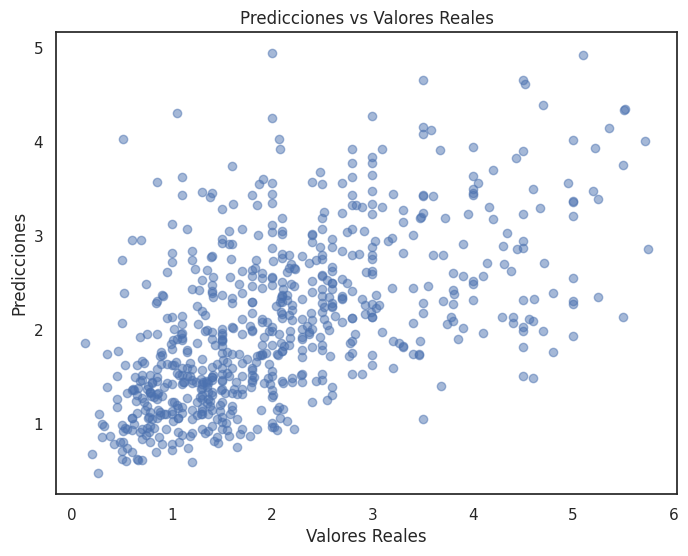

In [84]:
# Gráfico de dispersión entre predicciones y valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rf, y_test_rf_pred, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()

In [85]:
# Dataframe con los valores reales y predichos

df_rf_real_pred = pd.DataFrame({
    'Actual': y_test_rf,
    'Predicted': y_test_rf_pred
})

df_rf_real_pred

,Actual,Predicted
969,3.0000,2.138422
1695,1.6000,1.587256
1490,2.1730,1.985104
1522,1.3000,1.421867
2222,0.7500,0.948979
...,...,...
867,3.4000,2.445314
1962,0.5140,0.806007
747,4.6000,3.496652
1791,1.2000,0.895663


In [86]:
# Evaluación del modelo
mse = mean_squared_error(y_test_rf, y_test_rf_pred)
r2 = r2_score(y_test_rf, y_test_rf_pred)
mae = mean_absolute_error(y_test_rf, y_test_rf_pred)
mape = mean_absolute_percentage_error(y_test_rf, y_test_rf_pred)
rmse = np.sqrt(mse)
score = random_forest_model.score(X_test_rf, y_test_rf)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R²): {r2}')
print(f'Error absoluto medio (MAE): {mae}')
print(f'Error porcentual absoluto medio (MAPE): {mape}')
# Raiz de Error Cuadratico medio (Raiz cuadrada de la distancia cuadratica promedio entre los valores reales y predichos)
print(f'El RMSE es: {rmse}')
print(f'Score del Modelo: {score}')

Error cuadrático medio (MSE): 0.9694894865364492
Coeficiente de determinación (R²): 0.3130181687480714
Error absoluto medio (MAE): 0.7331692574506241
Error porcentual absoluto medio (MAPE): 0.48539558750629686
El RMSE es: 0.9846265721259249
Score del Modelo: 0.3130181687480714


Nota: Para este módelo de "Random Forest" podemos sacar las siguientes conclusiones respecto a las métricas obtenidas:

- Error cuadrático medio (MSE): 0.9694894865364492
- Coeficiente de determinación (R²): 0.3130181687480714
- Error absoluto medio (MAE): 0.7331692574506241
- Error porcentual absoluto medio (MAPE): 0.48539558750629686
- El RMSE es: 0.9846265721259249
- Score del Modelo: 0.3130181687480714

Lo que vamos a hacer ahora es calcular los mejores hiperparámetros para este algoritmo, de esa forma tendremos los valores óptimos para que la performance no se degrade y así y todo podamos tener buenos resultados

#### Eligiendo los mejores hiperparámetros

In [87]:
# Uso de Grid Search para selección del modelo
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 500, 1000], 'max_leaf_nodes': [16, 24, 36]},
    {'bootstrap': [False], 'n_estimators': [100, 500], 'max_features': [2, 3, 4]},
  ]

rnd_clf = RandomForestRegressor(n_jobs=-1, random_state=42)

# train across 5 folds, that's a total of (9+6)*5=75 rounds of training 
grid_search = GridSearchCV(rnd_clf, param_grid, cv=5,
                           scoring='r2', return_train_score=True)

grid_search.fit(X_train_rf, y_train_rf)

/home/mbergallo/anaconda3/envs/coderhouse/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'max_leaf_nodes': [16, 24, 36],
                          'n_estimators': [100, 500, 1000]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [100, 500]}],
             return_train_score=True, scoring='r2')

In [89]:
# Mostramos cuales son los mejores parámetros
grid_search.best_params_

{'max_leaf_nodes': 36, 'n_estimators': 500}

In [90]:
# Mostramos cual es la mejor instancia 
grid_search.best_estimator_

RandomForestRegressor(max_leaf_nodes=36, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [91]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("R2 score:", mean_score, "-", "Parámetros:", params)

R2 score: 0.3528970211955631 - Parámetros: {'max_leaf_nodes': 16, 'n_estimators': 100}
R2 score: 0.35357888954002226 - Parámetros: {'max_leaf_nodes': 16, 'n_estimators': 500}
R2 score: 0.3532382110272979 - Parámetros: {'max_leaf_nodes': 16, 'n_estimators': 1000}
R2 score: 0.3575120741698009 - Parámetros: {'max_leaf_nodes': 24, 'n_estimators': 100}
R2 score: 0.3576968298524692 - Parámetros: {'max_leaf_nodes': 24, 'n_estimators': 500}
R2 score: 0.3578904784354888 - Parámetros: {'max_leaf_nodes': 24, 'n_estimators': 1000}
R2 score: 0.3587488250685985 - Parámetros: {'max_leaf_nodes': 36, 'n_estimators': 100}
R2 score: 0.35940197588464706 - Parámetros: {'max_leaf_nodes': 36, 'n_estimators': 500}
R2 score: 0.35931084286892184 - Parámetros: {'max_leaf_nodes': 36, 'n_estimators': 1000}
R2 score: 0.24047151910006223 - Parámetros: {'bootstrap': False, 'max_features': 2, 'n_estimators': 100}
R2 score: 0.24425811904906647 - Parámetros: {'bootstrap': False, 'max_features': 2, 'n_estimators': 500}
R

In [92]:
# Mostramos todos los parámetros de nuestro mejor estimador
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': 36,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### Vemos los resultados estimando con nuestro Best Estimator

In [93]:
# Seleccionamos el mejor modelo
random_forest_model_be = grid_search.best_estimator_

In [94]:
random_forest_model_be.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_leaf_nodes=36, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [95]:
y_test_rf_be_pred = random_forest_model_be.predict(X_test_rf)

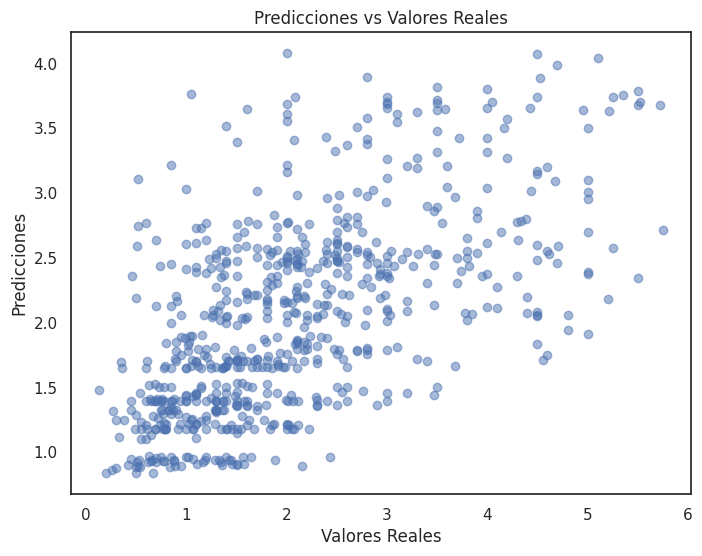

In [96]:
# Gráfico de dispersión entre predicciones y valores reales
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rf, y_test_rf_be_pred, alpha=0.5)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()

In [97]:
# Dataframe con los valores reales y predichos

df_rf_real_pred = pd.DataFrame({
    'Actual': y_test_rf,
    'Predicted': y_test_rf_be_pred
})

df_rf_real_pred

,Actual,Predicted
969,3.0000,2.460656
1695,1.6000,2.041602
1490,2.1730,1.854328
1522,1.3000,1.655947
2222,0.7500,1.326474
...,...,...
867,3.4000,2.897972
1962,0.5140,0.896164
747,4.6000,3.200560
1791,1.2000,1.248645


In [98]:
# Evaluación del modelo
mse = mean_squared_error(y_test_rf, y_test_rf_be_pred)
r2 = r2_score(y_test_rf, y_test_rf_be_pred)
mae = mean_absolute_error(y_test_rf, y_test_rf_be_pred)
mape = mean_absolute_percentage_error(y_test_rf, y_test_rf_be_pred)
rmse = np.sqrt(mse)
score = random_forest_model_be.score(X_test_rf, y_test_rf_be_pred)

print(f'Error cuadrático medio (MSE): {mse}')
print(f'Coeficiente de determinación (R²): {r2}')
print(f'Error absoluto medio (MAE): {mae}')
print(f'Error porcentual absoluto medio (MAPE): {mape}')
# Raiz de Error Cuadratico medio (Raiz cuadrada de la distancia cuadratica promedio entre los valores reales y predichos)
print(f'El RMSE es: {rmse}')
print(f'Score del Modelo: {score}')

Error cuadrático medio (MSE): 0.8797873167884188
Coeficiente de determinación (R²): 0.3765812725223344
Error absoluto medio (MAE): 0.7087287995257926
Error porcentual absoluto medio (MAPE): 0.4804212568919877
El RMSE es: 0.9379697845817949
Score del Modelo: 1.0


Nota: Para este módelo de "Random Forest - Con sus mejores parámetros" podemos sacar las siguientes conclusiones respecto a las métricas obtenidas:

- Error cuadrático medio (MSE): 0.8797873167884188
- Coeficiente de determinación (R²): 0.3765812725223344
- Error absoluto medio (MAE): 0.7087287995257926
- Error porcentual absoluto medio (MAPE): 0.4804212568919877
- El RMSE es: 0.9379697845817949
- Score del Modelo: 1.0

## Conclusión Final

Del EDA hemos podido responder dos de nuestras preguntas (Salarios sobre Residencia o sobre Estudios Alcanzados), ahora con nuestro anaálisis predictivo vamos a poder responder nuestra primer pregunta, predecir salarios en base a las variables del DataSet. Cada vez que exista nueva data sobre un nuevo DEV podrémos estimar el salario a ofrecerle a dicho candidato